<center><h2>DSCI 100 Group Project Proposal</h2></center>
<div style="text-align: right"> DSCI 100 008 </div>
<div style="text-align: right"> Group 21 </div>
<div style="text-align: right"> Ellie Wakefield </div>
<div style="text-align: right"> Ryan Lee </div>
<div style="text-align: right"> Samantha Tang </div>
<div style="text-align: right"> Soumil Ahuja </div>

<h3>Introduction</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Heart Disease “Cleveland data set” obtained from the UCI Machine Learning Repository will be used to predict the presence of heart disease. This dataset measures 66 different variables pertaining to heart disease for 303 participants. In order to determine the presence of heart disease, the dataset uses angiographic status. An angiography is recommended for patients that suffer from angina(chest pain) and is used to determine whether or not someone has heart disease. While the dataset classifies the angiography results into 4 levels of severity, we will simplify this and only look at whether heart disease is present (1) or absent (0).

<h3>Preliminary Exploratory Data Analysis</h3>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#loading data frame, assigning column names, changing angina column to factor type, & selecting the columns we need
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    rename(age=X1, sex=X2,chest_pain_type=X3, resting_blood_pressure=X4, serum_cholesteral=X5, fasting_blood_sugar=X6,
           resting_electrocardiographic_results=X7, max_heart_rate=X8, exercise_induced_angina=X9, ST_depression=X10,
           slope=X11, number_vessels=X12, thal=X13, angiographic_status=X14) |>
    mutate(exercise_induced_angina=as.factor(exercise_induced_angina)) |> 
    mutate(sex=as.factor(sex)) |>
    mutate(resting_electrocardiographic_results=as.factor(resting_electrocardiographic_results)) |>
    mutate(angiographic_status=as.factor(angiographic_status)) |>
    select(age, sex, resting_blood_pressure, serum_cholesteral, resting_electrocardiographic_results, exercise_induced_angina, angiographic_status)

#Create a new row to simplify
#angiographic_status of 0 means no presence of heart disease
#angiographic_status of more than 0 means heart disease
heart_data["heart_disease_presence"] <- 0
for(i in 1:nrow(heart_data)) {
    if(heart_data[i, ncol(heart_data)-1] == 0) {
        heart_data[i, ncol(heart_data)] <- 0
    } else {
        heart_data[i, ncol(heart_data)] <- 1
    }    
}
#no longer need angiograpic_status
heart_data <- heart_data |>
    select(-angiographic_status)
heart_data 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,resting_blood_pressure,serum_cholesteral,resting_electrocardiographic_results,exercise_induced_angina,heart_disease_presence
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
63,1,145,233,2,0,0
67,1,160,286,2,1,1
67,1,120,229,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,0,1,1
57,0,130,236,2,0,1
38,1,138,175,0,0,0


In [3]:
#Split up data into training and testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease_presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
#converts numerical sex value into a letter eg 0 -> F. Creates a new column for it
#done purely for the charts - F/M easier to read than 0/1
temp_heart_train <- heart_train
temp_heart_train["sex_letter"] <- NA
for(i in 1:nrow(temp_heart_train)) {
    if(temp_heart_train[i, 2] == 0) {
        temp_heart_train[i, ncol(temp_heart_train)] <- "F"
    } else {
        temp_heart_train[i, ncol(temp_heart_train)] <- "M"
    }    
}

#Table of mean age and cholesteral for each heart disease presence/sex combination
mean_age_angiographic <- temp_heart_train |>
    group_by(heart_disease_presence, sex_letter) |>
    summarize(mean_age=round(mean(age),1), mean_cholesteral = round(mean(serum_cholesteral)), n=n())
mean_age_angiographic

`summarise()` has grouped output by 'heart_disease_presence'. You can override
using the `.groups` argument.


heart_disease_presence,sex_letter,mean_age,mean_cholesteral,n
<dbl>,<chr>,<dbl>,<dbl>,<int>
0,F,53.3,259,54
0,M,51.5,229,69
1,F,59.5,274,21
1,M,56.7,248,83


`summarise()` has grouped output by 'sex_letter'. You can override using the
`.groups` argument.


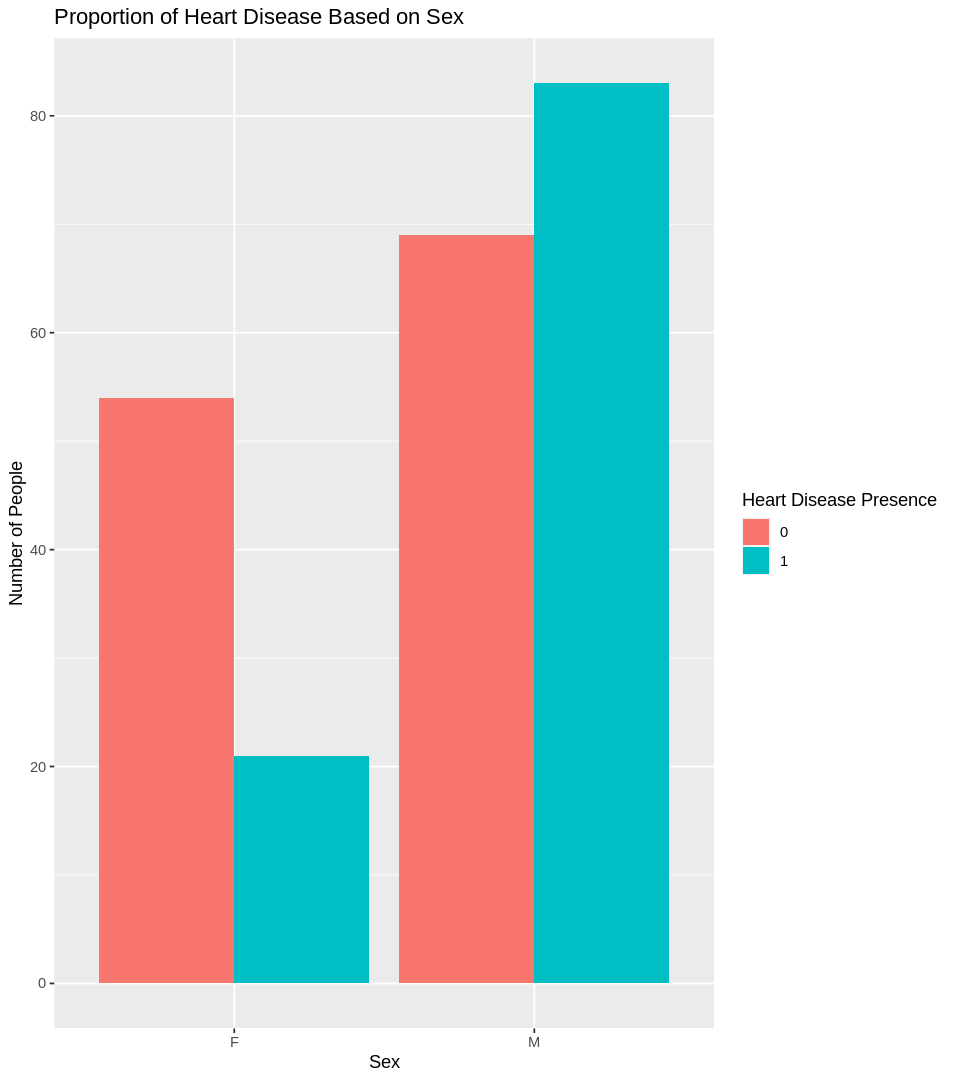

In [5]:
#Uses modified dataset purely for graphs/charts
#counts number of people in each sex/heart disease presence combination
temp_heart_train <- temp_heart_train |>
    group_by(sex_letter, heart_disease_presence) |>
    summarize(n=n())

temp_heart_train <- temp_heart_train |>
    mutate(heart_disease_presence = as.factor(heart_disease_presence))


options(repr.plot.width = 8, repr.plot.height = 9)
heart_plot <- temp_heart_train |> 
    ggplot(aes(x = sex_letter, y = n, fill = heart_disease_presence)) +
    geom_bar(stat = "identity", position = "dodge") +
    xlab("Sex") +
    ylab("Number of People") +
    labs(fill = "Heart Disease Presence")+
    ggtitle("Proportion of Heart Disease Based on Sex")
heart_plot

<h3>Methods</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In order to train our K-Nearest Neighbor classifier, we will use age, maximum heart rate, chest pain type, cholesterol, resting blood pressure, and gender as predictors. We chose these variables as they all correlated with heart disease. All of the data in the Cleveland Data Set will be used but will be split up into a training and a testing group with a 75 25 split. In order to pick the correct number for K, we will show a graph plotting the number of neighbors versus accuracy estimates. We will then show a confusion matrix using the K result with the highest accuracy. This will allow us to see the amount of type I and type II errors in comparison to the true positives and negatives.

<h3>Expected Outcomes and Significance</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall, we expect that each predictor will have a correlation to the presence of heart disease. We also anticipate that certain predictors such as cholesterol and angina will have a stronger relationship with angiographic status. For example, a higher level of cholesterol in the blood could correlate to the presence of heart disease. In addition, chest pain (angina) is an abnormal symptom to experience, which can often be linked to a higher chance of heart disease.
<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;These findings could help to determine the preventative measures of heart disease, such as lowering cholesterol levels or monitoring angina via checkups. These findings can determine symptoms that relate to heart disease so one can be more aware of the risks due their personal status. The results from this classifier and dataset can potentially act as a preventative measure as knowing which factors are highly correlated to heart disease could encourage some to watch their own health. For others with declining health, this classifier could classify some with early stages of heart disease. These early stages are often not as noticeable so awareness is key for any interventions. Future projects could focus on which variables better predict heart disease. While our predictors could work, other variables could be used because they correlate.
